In [11]:
import pandas as pd 
import numpy as np
import networkx as nx
import pickle
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.spatial.distance as spsd
import scipy.linalg as spla
import sys
import random
import math
import itertools
import scipy as sp
import scipy.stats
from sklearn import datasets, linear_model
from math import sqrt
import regressors
from regressors import stats


In [12]:
df = pd.read_csv("./Data/preprocess_data.csv")
df=df.drop(columns=['WEIGHT','HEIGHT'])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
y = df.BODYFAT
x = df.iloc[:,3:] # Dropping Bodyfat as well as Density, as it is an almost perfect predictor.
name=x.columns.tolist()
n=len(df)

In [14]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()
lasso_reg.fit(x,y)

bodyfat_predictions_l = lasso_reg.predict(x)
lasso_rmse = np.sqrt(mean_squared_error(y,bodyfat_predictions_l))
print("Lasso Root Mean Squared Error:", lasso_rmse)

Lasso Root Mean Squared Error: 4.101344305254341


In [15]:
print("Intercept:", lasso_reg.intercept_)
print("\nCoefficients:\n--------------")
b = pd.Series(lasso_reg.coef_,index=x.columns)
b.loc[lambda x: x!=0]

Intercept: -38.872876032040104

Coefficients:
--------------


AGE          0.002093
ABDOMEN      0.838159
WEIGHT_KG   -0.244658
dtype: float64

In [16]:
regressors.stats.summary(lasso_reg, x, y,xlabels=name)

Residuals:
     Min      1Q  Median     3Q     Max
-10.1755 -2.9786 -0.0265 2.9991 11.3068


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept -38.872876   16.447420  -2.3635  0.018868
AGE          0.002093    0.022993   0.0910  0.927549
ADIPOSITY    0.000000    0.226066   0.0000  1.000000
NECK        -0.000000    0.191546  -0.0000  1.000000
CHEST        0.000000    0.073721   0.0000  1.000000
ABDOMEN      0.838159    0.071666  11.6954  0.000000
HIP         -0.000000    0.088637  -0.0000  1.000000
THIGH        0.000000    0.124522   0.0000  1.000000
KNEE        -0.000000    0.214541  -0.0000  1.000000
ANKLE       -0.000000    0.197558  -0.0000  1.000000
BICEPS       0.000000    0.156536   0.0000  1.000000
FOREARM      0.000000    0.178924   0.0000  1.000000
WRIST       -0.000000    0.480794  -0.0000  1.000000
WEIGHT_KG   -0.244658    0.042404  -5.7696  0.000000
HEIGHT_M    -0.000000    3.824742  -0.0000  1.000000
---
R-squared:  0.71466,    Adjusted R-square

In [17]:
#prediction levels
predictions = lasso_reg.get_prediction(predict_x)
predictions.summary_frame(alpha=0.05)

AttributeError: 'Lasso' object has no attribute 'get_prediction'

# Diagnostics

## linear regression assumption

Basically, the performance of the Lasso is well understood under the assumptions of the standard linear model. Here we mainly focus on homoscedasticity. See figure, the general impression is residuals are randomly distributed around zero. No evidence for heteroscedasiticity. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


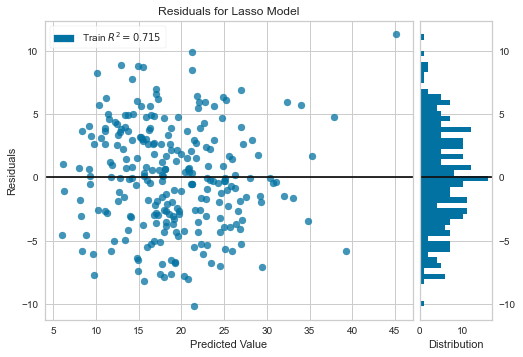

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
#内样本
from yellowbrick.regressor import ResidualsPlot

# Instantiate and fit the visualizer
visualizer_residuals = ResidualsPlot(lasso_reg)
visualizer_residuals.fit(x, y)
visualizer_residuals.show()

## outlier or high leverage point

We also want to detect high leverage points and outliers. Cook's distance is adequate for detection. From the cook's distance plot, there are two high influence points.The first one seems clear: He has the largest weight in the whole dataset, while the second one doesn't show any obvious difference from other samples.

In [19]:
from yellowbrick.base import Visualizer
import scipy as sp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [46]:
# Implemented but didn't use
class CooksDistance(Visualizer):
    
    def fit(self, X, y):
        # Leverage is computed as the diagonal of the projection matrix of X 
        # TODO: whiten X before computing leverage
        self.leverage_ = (X * np.linalg.pinv(X).T).sum(1)
        
        # Compute the MSE
        rank = np.linalg.matrix_rank(X)
        df = X.shape[0] - rank
        
        resid = y - lasso_reg.fit(X, y).predict(X)
        mse = np.dot(resid, resid) / df 
        
        resid_studentized_internal = resid / np.sqrt(mse) / np.sqrt(1-self.leverage_)
        
        self.distance_ = resid_studentized_internal**2 / X.shape[1]
        self.distance_ *= self.leverage_ / (1 - self.leverage_)

        self.p_values_ = sp.stats.f.sf(self.distance_, X.shape[1], df)
        
        return self
    
    
    def draw(self):
        self.ax.stem(self.distance_, markerfmt=",", label="influence")
        self.ax.axhline(4/len(self.distance_), c='r', ls='--', lw=1, label="$\frac{4}{n}$")
    
    def finalize(self):
        self.ax.legend()
        self.ax.set_xlabel("instance")
        self.ax.set_ylabel("influence")
        self.ax.set_title("Cook's Distance Outlier Detection")

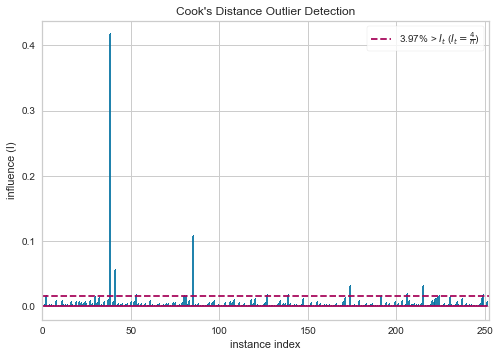

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [51]:
from yellowbrick.regressor import CooksDistance
# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(x, y)
visualizer.show()

In [52]:
visualizer.distance_[visualizer.distance_>0.05]

38    0.416782
41    0.055931
85    0.107991
dtype: float64

In [54]:
data.loc[[38, 41,85],:].T

,38,41,85
IDNO,39.00000,42.0000,86.0000
BODYFAT,33.80000,31.7000,25.8000
DENSITY,1.02020,1.0250,1.0386
AGE,46.00000,44.0000,67.0000
WEIGHT,363.15000,205.0000,167.0000
HEIGHT,72.25000,69.5000,67.5000
ADIPOSITY,48.90000,29.9000,26.0000
NECK,51.20000,36.6000,36.5000
CHEST,136.20000,106.0000,98.9000
ABDOMEN,148.10000,104.3000,89.7000


In [55]:
data_drop=df.drop([38, 85],axis=0)
clf = linear_model.Lasso(alpha=1)
clf.fit(data_drop.loc[:, data_drop.columns != 'BODYFAT'],data_drop['BODYFAT'])
print(clf.coef_)
#[0.85 0.  ]
print(clf.intercept_)
#0.15...
print(clf.score)

[-0.00230777 -0.          0.00462459  0.         -0.         -0.
  0.8307892  -0.          0.         -0.         -0.          0.
  0.         -0.         -0.21201182 -0.        ]
-40.63467515175243
<bound method RegressorMixin.score of Lasso(alpha=1)>


In [56]:
clf.score(data_drop.loc[:, data_drop.columns != 'BODYFAT'],data_drop['BODYFAT'])

0.7234556778711334

## overfitting and test performance

By now, what we show is still the model performance on the train dataset. Out-of-sample performance is also necessary for our sample. The coeffecient of determination is computed as the performance score on test data and train data. See figure. With the larger lambda, the variables in the model are less, but test score is non-decreasing. Therefore, the models with more strict penalty on variable selection will perform as well as those without penalty.
Another surprise is the train score. Althought the larger lambda results in a drop in the train score, it not a bad idea. The improving performance on test data claims that we actually are getting out of the overfitting trap.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:681: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e+03, tolerance: 1.178e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

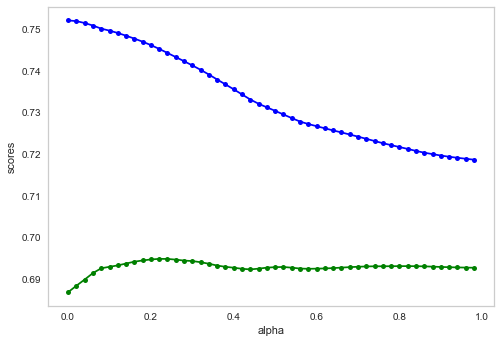

In [84]:
from sklearn.model_selection import validation_curve
import numpy as np
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
train_scores, test_scores = validation_curve(
    linear_model.Lasso(), x.loc[indices], y[indices], param_name="alpha", param_range=np.arange(0, 1, 0.02),
    cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
#
# Plot the model scores (accuracy) against the paramater range
#
plt.plot(np.arange(0, 1, 0.02), train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(np.arange(0, 1, 0.02), test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('alpha')
plt.ylabel('scores')
plt.grid()
plt.show()

Intuitively, we want to identify which feature is the most important in the data. Here we calculate the importance based on the feature influece on the r square.

In [85]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, x, y,
                           n_repeats=30,
                           random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{x.columns[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

ABDOMEN 2.748 +/- 0.210
WEIGHT  0.387 +/- 0.038
Unnamed: 00.001 +/- 0.002
AGE     0.000 +/- 0.000
WRIST   0.000 +/- 0.000
FOREARM 0.000 +/- 0.000
BICEPS  0.000 +/- 0.000
ANKLE   0.000 +/- 0.000
KNEE    0.000 +/- 0.000
HIP     0.000 +/- 0.000
CHEST   0.000 +/- 0.000
NECK    0.000 +/- 0.000
ADIPOSITY0.000 +/- 0.000
HEIGHT  0.000 +/- 0.000
THIGH   -0.000 +/- 0.001


In [86]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    clf, x, y, n_repeats=30, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {x.columns[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    ABDOMEN 2.748 +/- 0.210
    WEIGHT  0.387 +/- 0.038
neg_mean_absolute_percentage_error
    ABDOMEN 0.526 +/- 0.043
    WEIGHT  0.066 +/- 0.013
    THIGH   0.002 +/- 0.001
    AGE     0.000 +/- 0.000
neg_mean_squared_error
    ABDOMEN 162.024 +/- 12.395
    WEIGHT  22.824 +/- 2.239
